# Determining which functions are related to slowdown
Looking at simulation data with instantaneous switching moves. Using GPUs on shared mode on Hal with script

`python2.7 run_saltswap.py -i waterbox.pdb --gpu -o instsw.pdb -d instsw.txt -s 25000 --nkernals 0 --profile`

Each MD/MC iteration was profiles with `cProfile`, and the analysis below is trying to break-down which components are taking longer to evaluate.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pstats

Each iteration has been profiled. I want to see which parts of the code are slowing down.
Reading in and outputing the data from cProfile. Below is an example on how to use the `pstats` to read and print data from `cProfile`.:

In [2]:
filename = "profiles/profile0"       # The name of the output from profile
number=10                   # The number of functions whose times will be printed out
p = pstats.Stats(filename)
p.strip_dirs()
p.sort_stats('cumulative').print_stats(number)       # Printing my total time spent with function

Thu Jun  9 13:50:29 2016    profiles/profile0

         1122875 function calls (1121067 primitive calls) in 21.110 seconds

   Ordered by: cumulative time
   List reduced from 118 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   21.110   21.110 <string>:1(<module>)
        1    0.000    0.000   21.110   21.110 run_saltswap.py:99(profile_bundle)
        1    0.000    0.000   16.059   16.059 openmm.py:14787(step)
        1   16.059   16.059   16.059   16.059 {_openmm.CompoundIntegrator_step}
        1    0.001    0.001    5.051    5.051 saltswap.py:597(update)
      100    0.030    0.000    5.050    0.050 saltswap.py:325(attempt_identity_swap)
      200    1.492    0.007    1.492    0.007 {numpy.core.multiarray.array}
      600    0.007    0.000    1.356    0.002 openmm.py:13737(getState)
      600    0.001    0.000    1.344    0.002 openmm.py:13732(_getStateAsLists)
      600    0.608    0.001    1.343  

<pstats.Stats instance at 0x109edf0e0>

I can get the cumlative run time for a given function with calls like this:

In [3]:
p.stats[('saltswap.py', 325, 'attempt_identity_swap')][3]

5.049696

Next, I can see whether the slowdown in MD is correlated with a slowdown in the MC (salt deletion and insertion).

In [4]:
time_openmm = []
time_swap = []
for i in range(199):
    filename = "profiles/profile"+str(i)
    p = pstats.Stats(filename)
    p.strip_dirs()
    time_swap.append(p.stats[('saltswap.py', 325, 'attempt_identity_swap')][3])
    time_openmm.append(p.stats[(('openmm.py', 14787, 'step'))][3])
    
time_openmm = np.array(time_openmm)
time_swap = np.array(time_swap)

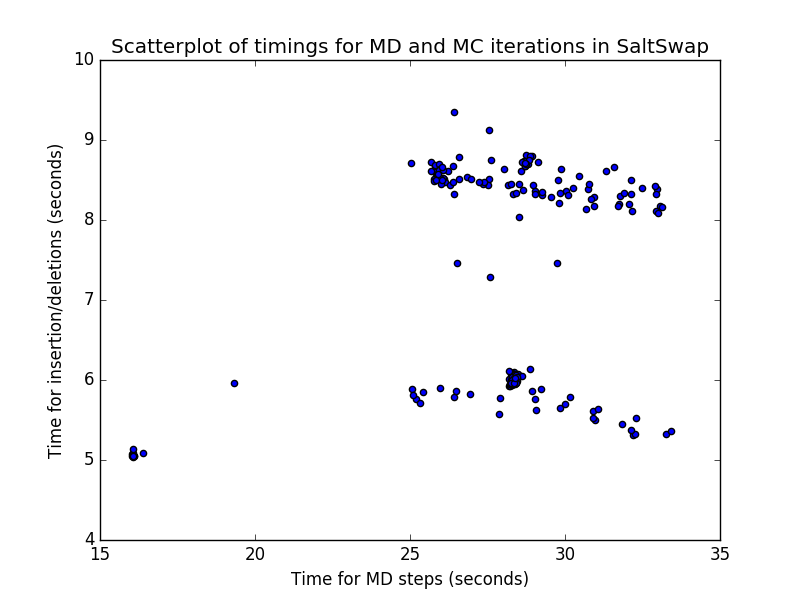

In [5]:
plt.scatter(x=time_openmm,y=time_swap)
plt.xlabel("Time for MD steps (seconds)")
plt.ylabel("Time for insertion/deletions (seconds)")
plt.title("Scatterplot of timings for MD and MC iterations in SaltSwap")
plt.savefig("TimeScatter.png", format='png')
Image("TimeScatter.png")

The result is very inconclusive. I can't really say if slow MD implies slow MC, or if the slowdown is restricted to either the to MC component in SaltSwap or the MD steps.

# Histograms of MD run times

Percentage fluctuation = 0.144859


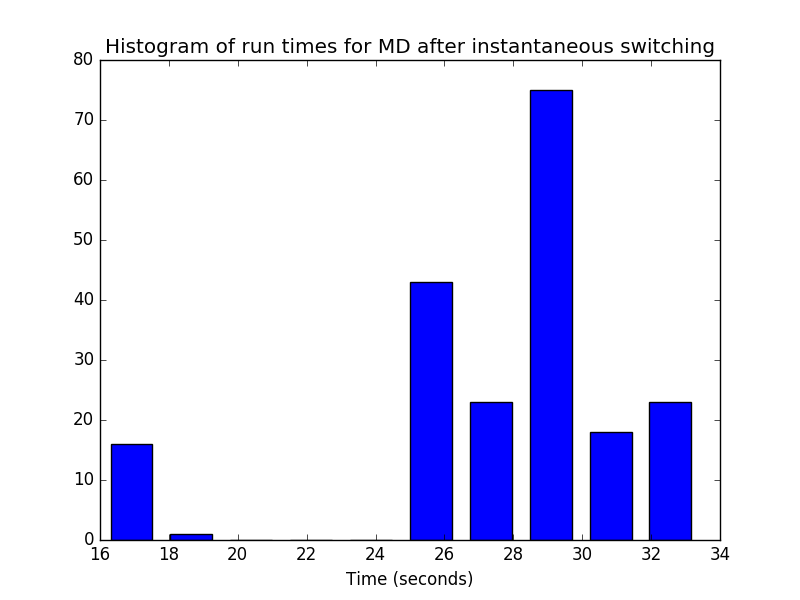

In [6]:
plt.clf()
hist,bins = np.histogram(time_openmm)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel("Time (seconds)")
plt.title("Histogram of run times for MD after instantaneous switching")
plt.savefig("Hist_MD_Inst.png",format="png")
print "Percentage fluctuation = {0:2f}".format(np.std(time_openmm)/np.mean(time_openmm)) 
Image("Hist_MD_Inst.png")

# Histograms of MC run times

Percentage fluctuation = 0.193686


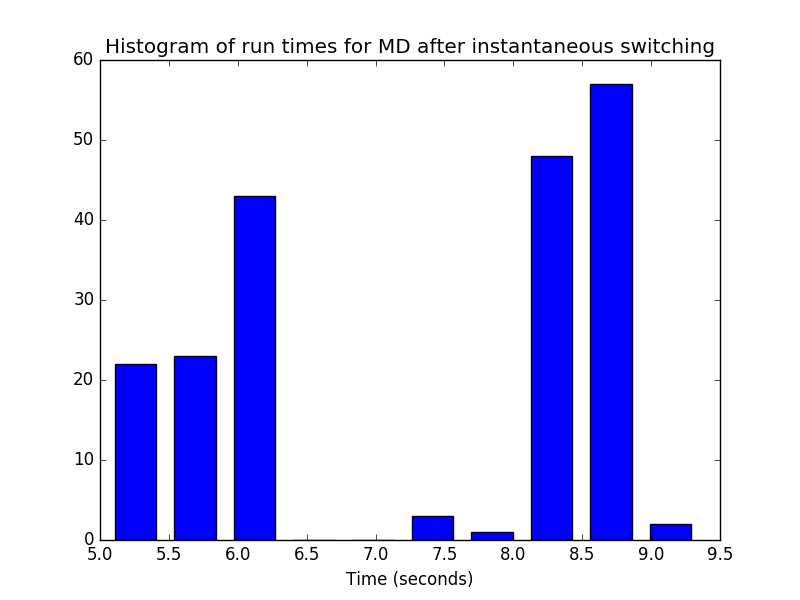

In [9]:
plt.clf()
hist,bins = np.histogram(time_swap)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel("Time (seconds)")
plt.title("Histogram of run times for MD after instantaneous switching")
plt.savefig("Hist_MC_Inst.png",format="png")
print "Percentage fluctuation = {0:2f}".format(np.std(time_swap)/np.mean(time_swap)) 
Image("Hist_MC_Inst.png")

Given the first plot, it seems these variances are uncorrelated, such that the variances are additive.